# SPECFEM Users Workshop -- Day 2 (Oct. 6, 2022)

## Part 2: Kernels and Adjoint Simulations 

In this notebook we will build upon the [Day 1 (Forward Simulation)](https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_1b_forward_simulations.ipynb) training to understand the construction of sensitivity kernels using adjoint simulations. These are key for performing seismic imaging as they can be used to guide iterative model updates during the inverse problem. We will introduce the concepts of misfit, adjoint sources, and kernels, as well as show Users how to perform adjoint simulations in SPECFEM2D.

-----------

### Relevant Information

>__NOTE:__ These instructions should be run from inside the Docker container, using Jupyter Lab. The Docker container should have the adjTomo toolkit installed (SeisFlows, Pyatoa, PySEP), as well as SPECFEM2D and SPECEFM3D compiled with MPI. 

**Relevant Links:** 
- Day 2 Slides !!! ADD THIS !!!
- [Today's Notebook](https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_2a_kernels.ipynb)
- Completed Notebook !!! ADD THIS !!!

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.


## 1) Background

!!! TO DO !!!
Potential topics:
- Misfit functions
- Adjoint Sources
- Sensitivity kernels
- Misfit kernels 

## 2) Setting Up 

As with Day 1, we will want to set up a clean working directory to run SPECFEM2D inside. This will help us preserve our cloned repository and reduce file clutter.

>__NOTE:__ We will be doing all our work in the directory /home/scoped/work_day_2. All the following cells assume that we are in this directory, so you must evaluate the '%cd' command to ensure that cells work as expected.

In [1]:
! mkdir /home/scoped/work/day_2
%cd /home/scoped/work/day_2

mkdir: cannot create directory ‘/home/scoped/work/day_2’: File exists
/home/scoped/work/day_2


In [2]:
# Symlink the binary files, and copy the relevant DATA/ directory
! ln -s /home/scoped/specfem2d/bin .
! cp -r /home/scoped/specfem2d/EXAMPLES/Tape2007/DATA .
! mkdir OUTPUT_FILES

In [3]:
! ls

bin  DATA  OUTPUT_FILES


### 2) Tape et al. 2007 Example

As with Day 1, we will be working with an Example problem from the [Tape et al. 2007 GJI publication](https://academic.oup.com/gji/article/168/3/1105/929373), which pre-defines a starting model, seismic sources and station locations. 

We will be revisiting the homogeneous halfspace model we saw in Day 1, as well as using a perturbation checkerboard model which defines a smooth checkerboard with $\pm$10\% velocity perturbations, overlain ontop of the homogeneous halfspace model. In the following sections we will visualize these models to help illustrate the experiemental setup.

In [4]:
! ls DATA/

interfaces_Tape2007.dat		  SOURCE_005  SOURCE_013  SOURCE_021
model_velocity.dat_checker	  SOURCE_006  SOURCE_014  SOURCE_022
Par_file_Tape2007_132rec_checker  SOURCE_007  SOURCE_015  SOURCE_023
Par_file_Tape2007_onerec	  SOURCE_008  SOURCE_016  SOURCE_024
SOURCE_001			  SOURCE_009  SOURCE_017  SOURCE_025
SOURCE_002			  SOURCE_010  SOURCE_018  STATIONS_checker
SOURCE_003			  SOURCE_011  SOURCE_019
SOURCE_004			  SOURCE_012  SOURCE_020


### a) The Homogeneous Halfspace Model

The homogeneous halfspace model in this example is defined in the `Par_file`, on Line 255. You can use the `seisflows sempar velocity_model` command to look at its values. The homogeneous halfspace model defines a region with P-wave velocity 5.8km/s and S-wave velocity 3.5km/s. We will not explore the halfspace model in as much detail as Day 1, but we plot it here for reference.

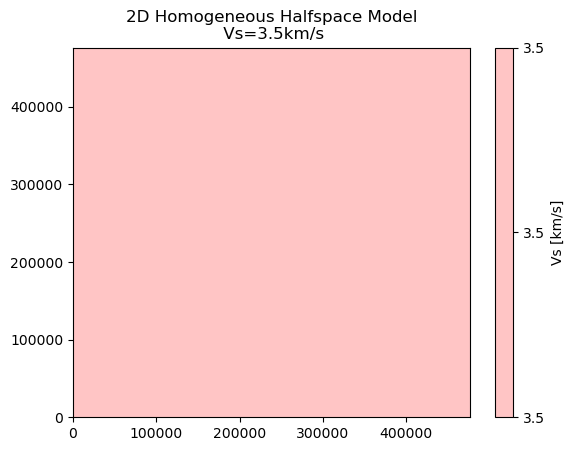

In [5]:
# Visualizing the homogeneous halfspace model
import numpy as np
import matplotlib.pyplot as plt


def plot_homogeneous_halfspace():
    """Plots a representation of the SPECFEM2D homogeneous halfspace model"""
    # Sets the X and Z dimensions of our mesh
    x = np.arange(0, 480000, 4000)
    z = np.arange(0, 480000, 4000)
    
    # Reformat the 1D arrays into 2D
    xv, zv = np.meshgrid(x, z)

    # Set a homogeneous value of Vs=3.5km/s 
    vs = 3.5 * np.ones(np.shape(xv))

    # Plot the arrays as a homogeneous halfspace
    plt.tricontourf(xv.flatten(), zv.flatten(), vs.flatten(), cmap="seismic_r", vmin=3.1, vmax=4.)
    plt.colorbar(label="Vs [km/s]", format="%.1f")
    plt.title("2D Homogeneous Halfspace Model\n Vs=3.5km/s")
    
# Calls the function we just defined
plot_homogeneous_halfspace()

### b) Perturbation Checkerboard Model

This Example problem also defines a perturbation checkerboard, which features smoothly varying Gaussian checkers that perturb the homogeneous halfspace model ($V_s$ and $V_p$) by roughly $\pm$10%.

We can use Matplotlib and NumPy to help us visualize these a bit better. First we'll have a look at the checkerboard model data file, and then we'll plot it directly.

In [6]:
# The columns of the data file correspond to the following:
# line_no x[m] z[m] density vp[m/s] vs[m/s]
! head DATA/model_velocity.dat_checker

	0	    0.0000	    0.0000	2600.0000	5800.0000	3500.0000
	1	 2072.0780	    0.0000	2600.0000	5800.0000	3500.0000
	2	 6000.0000	    0.0000	2600.0000	5800.0000	3500.0000
	3	 9927.9220	    0.0000	2600.0000	5800.0000	3500.0000
	4	12000.0000	    0.0000	2600.0000	5800.0000	3500.0000
	5	    0.0000	 2072.0780	2600.0000	5800.0000	3500.0000
	6	 2072.0780	 2072.0780	2600.0000	5800.2705	3500.3362
	7	 6000.0000	 2072.0780	2600.0000	5800.7824	3500.9724
	8	 9927.9220	 2072.0780	2600.0000	5801.2917	3501.6052
	9	12000.0000	 2072.0780	2600.0000	5801.5587	3501.9369


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Only grabbing X, Z, Vs and Vp
data = np.genfromtxt("DATA/model_velocity.dat_checker", dtype=float, usecols=[1,2,4,5])
chkbd_x, chkbd_z, chkbd_vp, chkbd_vs = data.T

# !!! NOTE THIS IS CURRENTLY BROKEN, WAITING ON PR 1151 (https://github.com/geodynamics/specfem2d/pull/1151) ON SPECFEM2D TO FIX !!!

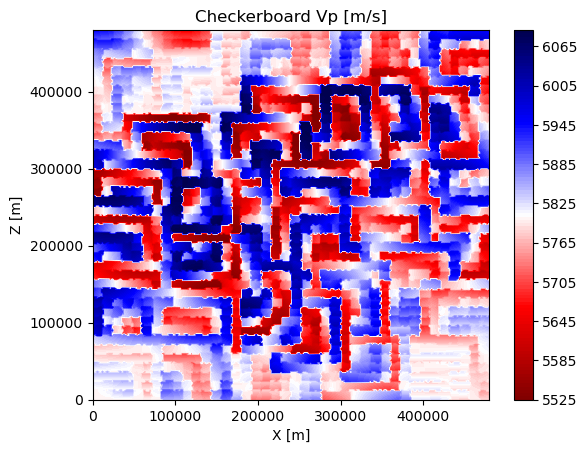

In [8]:
# Plotting Vp
plt.tricontourf(chkbd_x, chkbd_z, chkbd_vp, levels=125, cmap="seismic_r")
plt.xlabel("X [m]")
plt.ylabel("Z [m]")
plt.title("Checkerboard Vp [m/s]")
plt.colorbar()

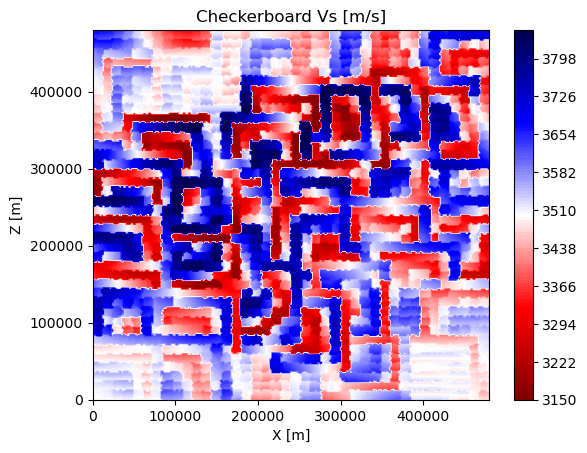

In [9]:
# Plotting Vs
plt.tricontourf(chkbd_x, chkbd_z, chkbd_vs, levels=125, cmap="seismic_r")
plt.xlabel("X [m]")
plt.ylabel("Z [m]")
plt.title("Checkerboard Vs [m/s]")
plt.colorbar()

### c) Visualizing Source-Receiver Geometry

We can similarly plot the SOURCES and STATIONS available to see what the experiemental setup looks like with respect to the Checkerboard model. This is the same operation performed in Day 1.

In [10]:
# Small code snippet to grab coordinates from STATIONS file
sta_x, sta_z = np.genfromtxt("DATA/STATIONS_checker", dtype=float, usecols=[2, 3]).T

In [11]:
# Small code snippet to grab coordinates from SOURCE files
ev_x, ev_z = [], []
for i in range(1, 26):
    source_file = f"DATA/SOURCE_{i:0>3}"
    with open(source_file, "r") as f:
        lines = f.readlines()
    # Trying to break apart the following line
    # 'xs = 299367.72      # source location x in meters\n'
    xs = float(lines[2].split("=")[1].split("#")[0].strip())
    zs = float(lines[3].split("=")[1].split("#")[0].strip())
    
    ev_x.append(xs)
    ev_z.append(zs)

Text(0.5, 1.0, 'SOURCE-RECEIVER GEOMETRY')

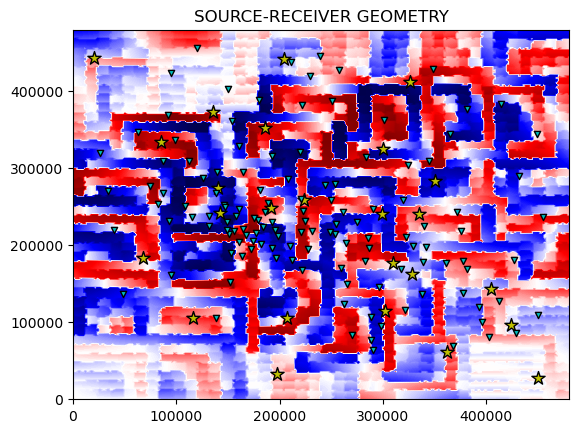

In [12]:
# Plot SOURCES and STATIONS together
plt.tricontourf(chkbd_x, chkbd_z, chkbd_vs, levels=250, cmap="seismic_r")
plt.scatter(ev_x, ev_z, c="y", marker="*", s=100, edgecolor="k")
plt.scatter(sta_x, sta_z, c="c", marker="v", s=20, edgecolor="k")
plt.title("SOURCE-RECEIVER GEOMETRY")

Text(0.5, 1.0, 'SOURCES')

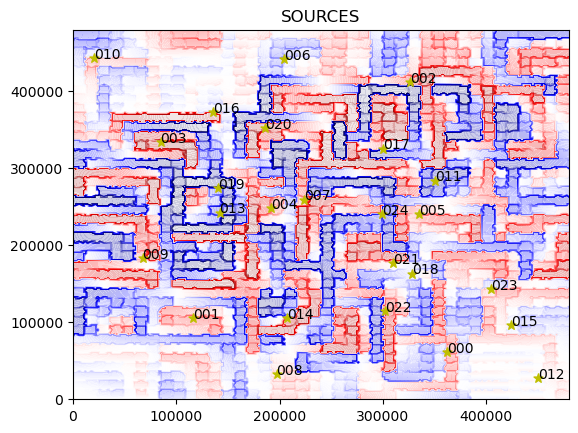

In [13]:
# Plot SOURCES next to source names
plt.tricontourf(chkbd_x, chkbd_z, chkbd_vs, levels=250, cmap="seismic_r", alpha=0.1)
for i, (x, z) in enumerate(zip(ev_x, ev_z)):
    plt.scatter(x, z, c="y", marker="*", s=45)
    plt.text(x, z, f"{i:0>3}")
plt.title("SOURCES")

Text(0.5, 1.0, 'STATIONS')

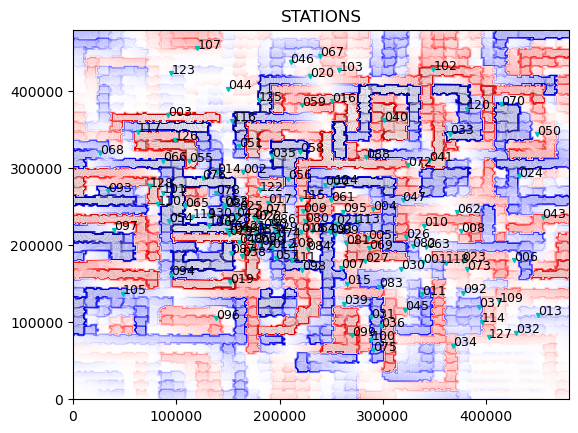

In [14]:
# Plot SOURCES and STATIONS together. Annotate names
plt.tricontourf(chkbd_x, chkbd_z, chkbd_vs, levels=250, cmap="seismic_r", alpha=0.1)
for i, (x, z) in enumerate(zip(sta_x, sta_z)):
    plt.scatter(x, z, c="c", marker="v", s=8)
    plt.text(x, z, f"{i:0>3}", fontsize=9)
plt.title("STATIONS")

In the above figures, the upside-down blue triangles represent the 132 receivers in this example, while the 25 yellow stars are the sources. Now that we are familiar with our experimental setup, we can run SPECFEM2D to generate synthetics.

## 2) Generating a Misfit Kernel

Sensitivity kernels show us what part of our model the waveform is sensitive to.  


### a) Generating 'Data' with a Target Model

We will use the Checkerboard model shown above as a True or Target model. The Target model is used to generate synthetic waveforms that are meant to approximate real world data. In the case of a real seismic inversion, one would substitute these data with actual waveforms recorded during an earthquake. 

In [15]:
# Setting up the SPECFEM2D Par_file
! ls DATA

interfaces_Tape2007.dat		  SOURCE_005  SOURCE_013  SOURCE_021
model_velocity.dat_checker	  SOURCE_006  SOURCE_014  SOURCE_022
Par_file_Tape2007_132rec_checker  SOURCE_007  SOURCE_015  SOURCE_023
Par_file_Tape2007_onerec	  SOURCE_008  SOURCE_016  SOURCE_024
SOURCE_001			  SOURCE_009  SOURCE_017  SOURCE_025
SOURCE_002			  SOURCE_010  SOURCE_018  STATIONS_checker
SOURCE_003			  SOURCE_011  SOURCE_019
SOURCE_004			  SOURCE_012  SOURCE_020


In [16]:
# Choose your SOURCE here
! cp DATA/SOURCE_001 DATA/SOURCE

In [17]:
# Write out a NEW stations file by choosing station numbers
# Change the range, or write your own list to choose station values
# e.g., STATION_CHOICE = [0, 1, 2, 3]

STATION_NUMBER_CHOICE = range(0, 1) 

# Read the existing stations file
stations = open("DATA/STATIONS_checker", "r").readlines()

# Write out only User defined stations
with open("DATA/STATIONS", "w") as f:
    for i in STATION_NUMBER_CHOICE:
        f.write(stations[i])

In [18]:
# Copy the Parameter file and make some adjustments 
! cp -f DATA/Par_file_Tape2007_132rec_checker DATA/Par_file

! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1

# Ensure that SPECFEM can find the checkerboard model by naming it correctly
! cp -f DATA/model_velocity.dat_checker DATA/proc000000_model_velocity.dat_input

SAVE_MODEL: default -> binary
setup_with_binary_database: 0 -> 1


In [19]:
# Run Meshfem and SPECFEM SPECFEM2D 
! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher.txt
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

OUTPUT_FILES/AA.S000000.BXY.semd


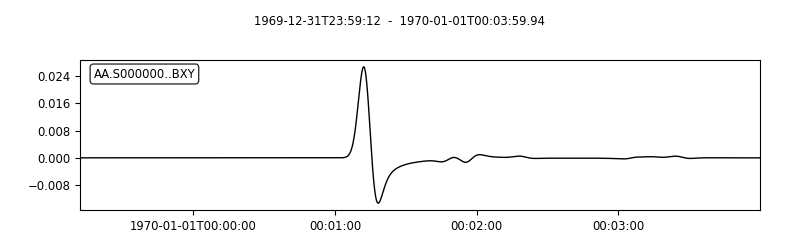

In [20]:
# We can look at the 'Data' waveform using SeisFlows
! ls OUTPUT_FILES/*semd
! seisflows plotst OUTPUT_FILES/AA.S000000.BXY.semd --savefig AA.S000000.BXY.semd.png

from IPython.display import Image
Image("AA.S000000.BXY.semd.png")

In [21]:
# Lets rename the OUTPUT_FILES so that our subsequent run doesn't overwrite files
! mv OUTPUT_FILES OUTPUT_FILES_TRUE
! mkdir OUTPUT_FILES

### b) Generating Synthetics using Initial Model

Now we want to generate a synthetic waveform using our starting or initial model. In this example we will use the homogeneous halfspace model as our starting model in order to generate our synthetic waveform. We will use the SAME source and receivers as the Target model, to ensure that we can compare the waveforms generated.

The idea here is that the waveform generated by the Target model and the waveform generated by the Initial model will be different, and the differences between these waveforms contains information about the differences in the models that created them (in this case, homogeneous halfspace versus checkerboard model).

In [22]:
# The SOURCE and STATIONS files should remain the same,
# we only want to tell SPECFEM to use the homogeneous halfspace model

! cp -f DATA/Par_file_Tape2007_onerec DATA/Par_file

! seisflows sempar -P DATA/Par_file use_existing_stations .true.
! seisflows sempar -P DATA/Par_file save_model binary
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1

use_existing_STATIONS: .false. -> .true.
SAVE_MODEL: default -> binary
setup_with_binary_database: 0 -> 1


In [23]:
# Run SPECFEM with the homogeneous halfspace model, defined in the Par_file
! mpirun -n 1 bin/xmeshfem2D > OUTPUT_FILES/output_mesher.txt
! mpirun -n 1 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

OUTPUT_FILES/AA.S000000.BXY.semd


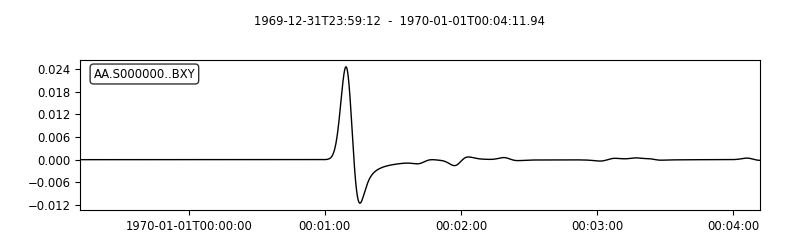

In [24]:
# Again we can look at the waveform. We will compare in the next section
! ls OUTPUT_FILES/*semd
! seisflows plotst OUTPUT_FILES/AA.S000000.BXY.semd --savefig AA.S000000.BXY.semd.png

Image("AA.S000000.BXY.semd.png")

In [25]:
! mv OUTPUT_FILES OUTPUT_FILES_INIT

### c) Misfit Quantification and Adjoint Sources

Let's start out by looking at the two waveforms together to see how they differ.

In [26]:
st_true = np.loadtxt("OUTPUT_FILES/AA.S000000.BXY.semd.png")

FileNotFoundError: OUTPUT_FILES/AA.S000000.BXY.semd.png not found.

### b) Setting up SPECFEM for an Adjoint Simulation

### c) Running an Adjoint Simulation

### d) Understanding Sensitivity Kernels

## 3) Generating a Misfit Kernel



### a) Generating an Adjoint Source with Python

### b) Generating an Adjoint Source with Pyatoa

### c) Setup and Run Adjoint Simulation

### d) Understanding Misfit Kernels

## 4) Automating Kernels with SeisFlows

In [ ]:
! seisflows examples run 2 -r /home/scoped/specfem2d --event_id 1 --niter 1 --with_mpi